In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install transformers
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
# !pip install pororo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 35.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
botocore 1.18.18 requires urllib3<1.26,>=1.20; python_version != "3.4", but you have urllib3 1.26.13 which is incompatible.
zsh:1: command not found: apt-get
The operation couldn’t be completed. Unable to locate a Java Runtime that supports apt.
Please visit http://www.java.com for information on installing Java.

     ━━━━━━━━━━━━

In [ ]:
# %cd /content/drive/MyDrive/MLM/

# Text Data Augmentation
https://github.com/seoyeon9646/MLM-data-augmentation
-> Clone 후 해당 폴더에서 진행

In [1]:
import copy
import torch
import tqdm
import argparse
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import numpy as np
import random
import os
import re
import time

from collections import Counter

from utils import mask_tokens
from tqdm import tqdm

from typing import Union
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM

# import pororo
# from pororo import Pororo

import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

plt.rc('font', family='NanumGothicOTF') # For MacOS
# plt.rc('font', family='NanumGothic') # For Windows
# print(plt.rcParams['font.family'])

# 증강할 데이터 추출

In [3]:
orig_data = pd.read_csv('train_dup.csv')

# 문장, 유형, 극성, 시제, 확실성, label 외 삭제
orig_data.drop(columns=['Unnamed: 0', 'ID'], inplace=True)
labels = orig_data.drop(columns=['문장'])

Text(0.5, 1.0, 'Distribution of certainty')

findfont: Font family 'NanumGothicOTF' not found.
findfont: Font family 'NanumGothicOTF' not found.
/opt/homebrew/Caskroom/miniforge/base/envs/dacon/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/dacon/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/dacon/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  func(*args, **kwargs)
findfont: Font family 'NanumGothicOTF' not found.
/opt/homebrew/Caskroom/miniforge/base/envs/dacon/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/mi

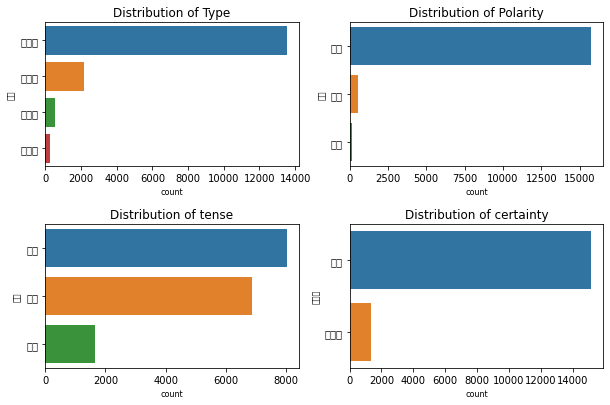

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.4)

g = sns.countplot(y="유형", data=orig_data,order = orig_data['유형'].value_counts().index , ax = axes[0][0])
axes[0][0].set_xlabel(g.get_xlabel(), fontsize=8)
axes[0][0].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[0][0].set_title('Distribution of Type')

g = sns.countplot(y="극성", data=orig_data,order = orig_data['극성'].value_counts().index , ax = axes[0][1])
axes[0][1].set_xlabel(g.get_xlabel(), fontsize=8)
axes[0][1].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[0][1].set_title('Distribution of Polarity')

g = sns.countplot(y="시제", data=orig_data,order = orig_data['시제'].value_counts().index , ax = axes[1][0])
axes[1][0].set_xlabel(g.get_xlabel(), fontsize=8)
axes[1][0].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[1][0].set_title('Distribution of tense')

g = sns.countplot(y="확실성", data=orig_data,order = orig_data['확실성'].value_counts().index , ax = axes[1][1])
axes[1][1].set_xlabel(g.get_xlabel(), fontsize=8)
axes[1][1].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[1][1].set_title('Distribution of certainty')

<AxesSubplot: xlabel='count', ylabel='label'>

/opt/homebrew/Caskroom/miniforge/base/envs/dacon/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/dacon/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/dacon/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/dacon/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/dacon/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from cu

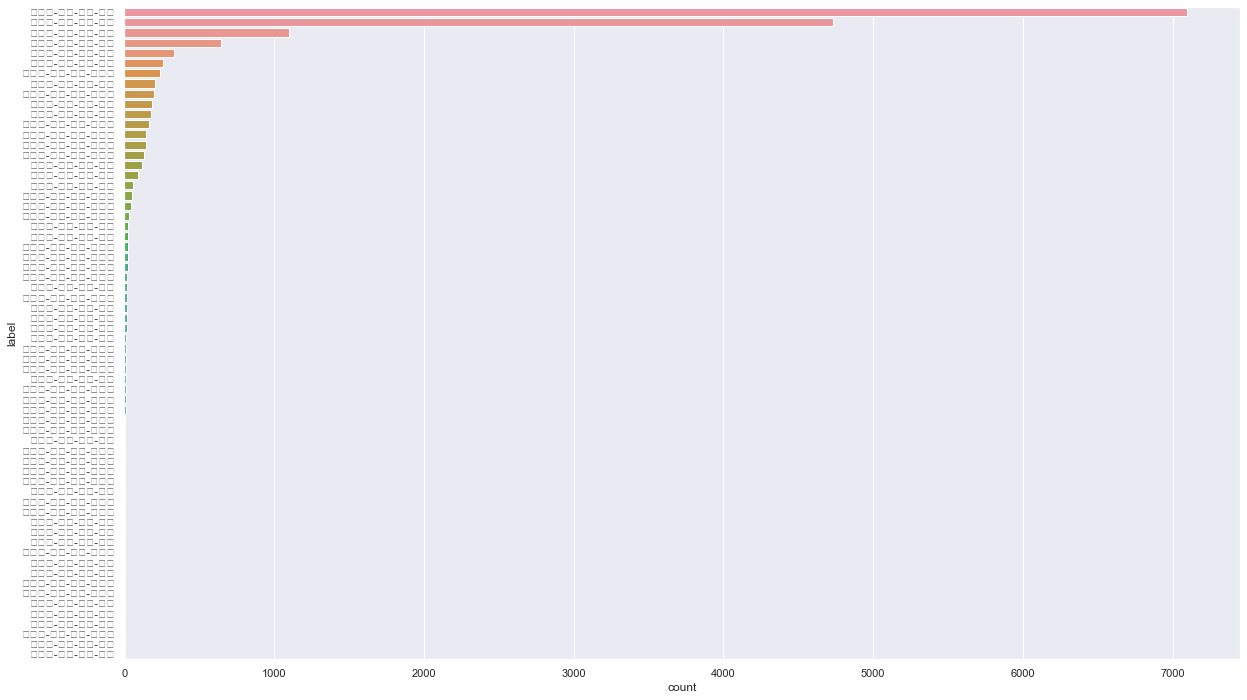

In [5]:
sns.set(rc = {'figure.figsize':(20,12)})
sns.countplot(y="label", data=orig_data,order = orig_data['label'].value_counts().index)

In [6]:
orig_data['label'].value_counts()

사실형-긍정-과거-확실     7098
사실형-긍정-현재-확실     4733
추론형-긍정-현재-확실     1099
사실형-긍정-미래-확실      647
추론형-긍정-과거-확실      334
                 ... 
대화형-미정-과거-확실        1
예측형-미정-현재-확실        1
예측형-부정-현재-불확실       1
예측형-부정-과거-확실        1
예측형-미정-과거-확실        1
Name: label, Length: 64, dtype: int64

In [7]:
df = orig_data.loc[orig_data.label != '사실형-긍정-과거-확실']
df = df.loc[df.label != '사실형-긍정-현재-확실']
df['label'].value_counts()

,문장,유형,극성,시제,확실성,label
2,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
11,취약점을 보완하기 위해 무작정 강력한 보안장치를 도입할 수도 없다.,추론형,부정,현재,확실,추론형-부정-현재-확실
12,비가 내리는 지역에서는 돌풍과 함께 천둥·번개가 치고 일부 지역에선 우박이 떨어지는...,예측형,긍정,미래,불확실,예측형-긍정-미래-불확실
17,서울 아파트 매매가격이 여전히 상승세를 이어가고 있기 때문이다.,추론형,긍정,현재,확실,추론형-긍정-현재-확실
21,1점 차로 초박빙 승부를 펼친 소리꾼 전영랑과 트로트 요정 강유진은 민요와 트로트의...,추론형,긍정,과거,확실,추론형-긍정-과거-확실
...,...,...,...,...,...,...
16492,"각종 해킹 및 신분증 위변조로 인한 사건,사고의 가능성도 배제할 수 없다.",사실형,부정,현재,확실,사실형-부정-현재-확실
16493,"국가의 허리인 중산층이 붕괴하고 있지만, 한국의 중산층 통계는 국민이 체감하는 중산...",추론형,긍정,현재,확실,추론형-긍정-현재-확실
16495,계약직으로 근무했던 초단시간 근로자의 일상과 도서관이라는 작은 사회를 통해 우리 사...,추론형,긍정,현재,확실,추론형-긍정-현재-확실
16496,뒷좌석에서 동승자나 별도로 안전하게 보관할 수 있는 애견가방 등을 준비하는 게 좋으...,추론형,긍정,현재,확실,추론형-긍정-현재-확실


In [33]:
df = df.reset_index(drop=True)
df

,문장,유형,극성,시제,확실성,label
0,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
1,취약점을 보완하기 위해 무작정 강력한 보안장치를 도입할 수도 없다.,추론형,부정,현재,확실,추론형-부정-현재-확실
2,비가 내리는 지역에서는 돌풍과 함께 천둥·번개가 치고 일부 지역에선 우박이 떨어지는...,예측형,긍정,미래,불확실,예측형-긍정-미래-불확실
3,서울 아파트 매매가격이 여전히 상승세를 이어가고 있기 때문이다.,추론형,긍정,현재,확실,추론형-긍정-현재-확실
4,1점 차로 초박빙 승부를 펼친 소리꾼 전영랑과 트로트 요정 강유진은 민요와 트로트의...,추론형,긍정,과거,확실,추론형-긍정-과거-확실
...,...,...,...,...,...,...
4666,"각종 해킹 및 신분증 위변조로 인한 사건,사고의 가능성도 배제할 수 없다.",사실형,부정,현재,확실,사실형-부정-현재-확실
4667,"국가의 허리인 중산층이 붕괴하고 있지만, 한국의 중산층 통계는 국민이 체감하는 중산...",추론형,긍정,현재,확실,추론형-긍정-현재-확실
4668,계약직으로 근무했던 초단시간 근로자의 일상과 도서관이라는 작은 사회를 통해 우리 사...,추론형,긍정,현재,확실,추론형-긍정-현재-확실
4669,뒷좌석에서 동승자나 별도로 안전하게 보관할 수 있는 애견가방 등을 준비하는 게 좋으...,추론형,긍정,현재,확실,추론형-긍정-현재-확실


# Back Translation

In [34]:
def chrome_setting():
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  driver = webdriver.Chrome('chromedriver', options=chrome_options)
  return driver

In [35]:
driver=chrome_setting()

In [36]:
# Crawling
def kor_to_trans(text_data, trans_lang,start_index,final_index):

  target_present = EC.presence_of_element_located((By.XPATH, '//*[@id="txtTarget"]'))

  for i in tqdm(range(start_index,final_index)): 
    
    if (i!=0)&(i%99==0):
      time.sleep(2)
      print('{}th : '.format(i), backtrans)
      np.save(data_path+'kor_to_eng_train_{}_{}.npy'.format(start_index,final_index),trans_list)
    
    try:
      driver.get('https://papago.naver.com/?sk=ko&tk='+trans_lang+'&st='+text_data[i].replace('%','%25'))
      time.sleep(1.5)
      element=WebDriverWait(driver, 10).until(target_present)
      time.sleep(0.1)
      backtrans = element.text 

      if (backtrans=='')|(backtrans==' '):
        element=WebDriverWait(driver, 10).until(target_present)
        backtrans = element.text 
        trans_list.append(backtrans)
      else:
        trans_list.append(backtrans)
    
    except:
      trans_list.append('')


In [37]:
data_path = ''

trans_list=[]
kor_to_trans(df['문장'], 'en',0,2500)
np.save(data_path+'kor_to_eng_train_0_2500.npy',trans_list)

trans_list=[]
kor_to_trans(df['문장'], 'en',2500,len(df))
np.save(data_path+'kor_to_eng_train_2500_all.npy',trans_list)

  4%|▍         | 99/2500 [03:04<1:09:53,  1.75s/it]

99th :  The strength of rules, formulas, and algorithms over humans lies not in superior insight, but in ＇ noiselessness.


  8%|▊         | 198/2500 [06:01<1:07:09,  1.75s/it]

198th :  ＂I believe in invisible accumulation.＂


 12%|█▏        | 297/2500 [08:56<1:04:12,  1.75s/it]

297th :  This is because depositors manage their funds in a ＇ short period of time, expecting interest rates to rise further in the future.


 16%|█▌        | 396/2500 [11:53<1:01:37,  1.76s/it]

396th :  It's a small travel agency run by a couple.


 20%|█▉        | 495/2500 [14:49<58:35,  1.75s/it]  

495th :  Both companies do not deny the related information, saying, "It is a good sale, so we are in the process of examining it internally."


 24%|██▍       | 594/2500 [17:45<55:50,  1.76s/it]  

594th :  The 2022 ＇ Aida＇ will once again present a dream stage with actors who worked on this work last season.


 28%|██▊       | 693/2500 [20:40<53:06,  1.76s/it]  

693th :  North Korea's announcement cannot be trusted.


 32%|███▏      | 792/2500 [23:36<50:28,  1.77s/it]  

792th :  It plans to continuously improve the accessibility of young people by expanding the online application method introduced in February this year.


 36%|███▌      | 891/2500 [26:33<47:04,  1.76s/it]  

891th :  In addition, if existing loan customers are damaged, they can benefit from a postponement of repayment of principal and interest and an extension of maturity depending on the results of the examination.


 40%|███▉      | 990/2500 [29:30<44:14,  1.76s/it]  

990th :  That was the case in early 1998, shortly after the International Monetary Fund (IMF) crisis.


 44%|████▎     | 1089/2500 [32:26<41:16,  1.75s/it]

1089th :  At the same time, the company will also work from home for two weeks from the 9th.


 48%|████▊     | 1188/2500 [35:23<38:32,  1.76s/it]

1188th :  This is the result of slow growth and the won's depreciation against the dollar.


 51%|█████▏    | 1287/2500 [38:19<35:29,  1.76s/it]

1287th :  There is this sentence in Messner's book ＇Black Solitude White Solitude.


 55%|█████▌    | 1386/2500 [41:15<32:55,  1.77s/it]

1386th :  In addition, an event will be held to predict three ＇CompMagles＇ who will serve as the official promotional model for ＇CompMag 2020＇ this year.


 59%|█████▉    | 1485/2500 [44:12<29:50,  1.76s/it]

1485th :  망나니가 사람을 죽일 때 칼을 씻던 ＇뚜께우물＇이 이곳에서 발견되어 역사 속 순교를 확인할 수 있다.


 63%|██████▎   | 1584/2500 [47:08<27:00,  1.77s/it]

1584th :  In response, King Hyojong rejoiced, saying, "If you become a king, no one will be unfairly killed."


 67%|██████▋   | 1683/2500 [50:05<23:55,  1.76s/it]

1683th :  Cities with concentrated populations and knowledge are very efficient systems for economic growth, but they are also very vulnerable to the spread of fear.


 71%|███████▏  | 1782/2500 [53:01<21:02,  1.76s/it]

1782th :  The general strike by the Korea Cargo Workers' Union seems to have spread damage to the entire industry.


 75%|███████▌  | 1881/2500 [55:58<18:10,  1.76s/it]

1881th :  Mesner's mountain literature is scary and beautiful.


 79%|███████▉  | 1980/2500 [58:54<15:15,  1.76s/it]

1980th :  To hit more than 400 yards, several conditions must be met at the same time.


 83%|████████▎ | 2079/2500 [1:01:51<12:26,  1.77s/it]

2079th :  I hope Lee will not lose his conviction in front of power.


 87%|████████▋ | 2178/2500 [1:04:48<09:28,  1.77s/it]

2178th :  GAA has a structure in which all sides of a circuit come into contact with a gate that controls current, which can reduce chip area by 35% compared to 5-nano products that Samsung Electronics recently developed, while reducing power consumption by 50% and improving processing speed by about 30%.


 91%|█████████ | 2277/2500 [1:07:44<06:34,  1.77s/it]

2277th :  This is because taxes previously paid to one country may have to be paid separately to dozens of export target countries.


 95%|█████████▌| 2376/2500 [1:10:41<03:40,  1.78s/it]

2376th :  CU, a convenience store, joined hands with Yonsei University's ＇Yonsei Milk to introduce ＇Yonsei Fresh Cream Bread in February.＇ The momentum of the three types is also unusual.


 99%|█████████▉| 2475/2500 [1:13:37<00:43,  1.76s/it]

2475th :  In the future, LG Display will launch a ＇challenge program to discover new business opportunities for startups.


  3%|▎         | 74/2171 [02:10<1:01:26,  1.76s/it]

2574th :  You can check the power of creative musicals with a stage that is not boring.


  8%|▊         | 173/2171 [05:07<58:31,  1.76s/it]  

2673th :  In addition, an event to receive generous rewards using commemorative coins will be held from the 4th of next month to mark the 13th anniversary of the slugger service.


 13%|█▎        | 272/2171 [08:03<55:30,  1.75s/it]  

2772th :  However, McLeigh said, "It is difficult to think that China will maintain a centralized political system until then."


 17%|█▋        | 371/2171 [11:01<53:13,  1.77s/it]  

2871th :  If the quota regulations are eased and the number of students increases, Korean students can also be given high-quality educational opportunities instead of Chinese students.


 22%|██▏       | 470/2171 [13:58<49:50,  1.76s/it]  

2970th :  Various projects and events will serve as a base for the inheritance and development of the bride's three major spirits: Serving, Joy, and Sharing.


 26%|██▌       | 569/2171 [16:53<46:59,  1.76s/it]  

3069th :  By applying the same 3D voice conversation system as in real life, the sense of reality has also been enhanced.


 31%|███       | 668/2171 [19:50<44:17,  1.77s/it]  

3168th :  ＂What are your plans for domestic distribution in the future?＂


 35%|███▌      | 767/2171 [22:47<43:01,  1.84s/it]

3267th :  There is also a way to secure domestic and foreign currency sovereignty in mobile pay checks.


 40%|███▉      | 866/2171 [25:43<38:08,  1.75s/it]

3366th :  ＂By the way, our game company says, "I'll just put NFT on the game item."＂


 44%|████▍     | 965/2171 [28:37<34:49,  1.73s/it]

3465th :  The sorghum flower bridge is mainly grown in North Korea, but it is also planted in the central part of Korea, and it can be said that it is a case of gardening due to successful transplantation, not native transplantation.


 49%|████▉     | 1064/2171 [31:32<32:29,  1.76s/it]

3564th :  Taiwan's ＇Waho Jangryong ($128.08 million), which recorded the highest sales of non-English films released in North America, has a long way to go, but it is not entirely unlikely.


 54%|█████▎    | 1163/2171 [34:27<29:20,  1.75s/it]

3663th :  At least 500 people, including national athletes, partner players and coaching staff, and International Wrestling Federation's scholarship program for developing countries, will participate in training and friendly matches at Yangsan Indoor Gymnasium.


 58%|█████▊    | 1262/2171 [37:23<26:39,  1.76s/it]

3762th :  If your glare intensifies after spending time under strong sunlight like mountains and seas, you should suspect wide keratitis.


 63%|██████▎   | 1361/2171 [40:18<23:37,  1.75s/it]

3861th :  It is also equipped with a sound wave vibrating wet mop system that vibrates up to 3,000 times per minute with double the suction power.


 67%|██████▋   | 1460/2171 [43:13<20:57,  1.77s/it]

3960th :  The ruling Democratic Party of Korea said on the 3rd that the ＂ Fair Trade Commission should strictly review the principles of corporate combination screening and take a close look at the monopoly of delivery applications.＂ The merger may eventually fail if the voices of self-employed people concerned about raising brokerage fees are strongly reflected.


 72%|███████▏  | 1559/2171 [46:08<17:56,  1.76s/it]

4059th :  After that, it plans to start developing monoclonal antibody treatments using recombination technology.


 76%|███████▋  | 1658/2171 [49:03<14:58,  1.75s/it]

4158th :  Discussions were scheduled to establish strategies and frameworks for game industry issues and the Yoon Suk Yeoln government's game policy, and Kim Jin-pyo, who will be elected as the chairman of the 21st National Assembly, and Park Bo-kyun, Minister of Culture, Sports and Tourism, will attend and deliver a congratulatory speech.


 81%|████████  | 1757/2171 [51:59<12:05,  1.75s/it]

4257th :  You can have an opportunity to talk to global pharmaceutical companies and bio-tech talent, which are usually difficult to meet.


 85%|████████▌ | 1856/2171 [54:54<09:11,  1.75s/it]

4356th :  Bob Bocky's reputation is alive and well, so expectations are high for SM8's performance.


 90%|█████████ | 1955/2171 [57:50<06:18,  1.75s/it]

4455th :  ＂I know all too well that one day everything will be gone.＂


 95%|█████████▍| 2054/2171 [1:00:45<03:25,  1.75s/it]

4554th :  And the market seems to be paying more attention to these worst-prepared companies.


 99%|█████████▉| 2153/2171 [1:03:40<00:31,  1.74s/it]

4653th :  Should I let go of the word "organization" forever in my life?


100%|██████████| 2171/2171 [1:04:13<00:00,  1.78s/it]


In [38]:
eng_data0=np.load(data_path+'kor_to_eng_train_0_2500.npy')
eng_data1=np.load(data_path+'kor_to_eng_train_2500_all.npy')

eng_data=[*eng_data0,*eng_data1]
eng_data=pd.DataFrame(eng_data,columns=['eng_text'])

In [39]:
back_train=pd.concat([df,eng_data],axis=1)
back_train

,문장,유형,극성,시제,확실성,label,eng_text
0,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실,The government will expand the range of oil ta...
1,취약점을 보완하기 위해 무작정 강력한 보안장치를 도입할 수도 없다.,추론형,부정,현재,확실,추론형-부정-현재-확실,It is also not possible to introduce strong se...
2,비가 내리는 지역에서는 돌풍과 함께 천둥·번개가 치고 일부 지역에선 우박이 떨어지는...,예측형,긍정,미래,불확실,예측형-긍정-미래-불확실,There will be thunder and lightning along with...
3,서울 아파트 매매가격이 여전히 상승세를 이어가고 있기 때문이다.,추론형,긍정,현재,확실,추론형-긍정-현재-확실,This is because apartment sales prices in Seou...
4,1점 차로 초박빙 승부를 펼친 소리꾼 전영랑과 트로트 요정 강유진은 민요와 트로트의...,추론형,긍정,과거,확실,추론형-긍정-과거-확실,Singer Jeon Young-rang and trot fairy Kang Yoo...
...,...,...,...,...,...,...,...
4666,"각종 해킹 및 신분증 위변조로 인한 사건,사고의 가능성도 배제할 수 없다.",사실형,부정,현재,확실,사실형-부정-현재-확실,The possibility of incidents and accidents cau...
4667,"국가의 허리인 중산층이 붕괴하고 있지만, 한국의 중산층 통계는 국민이 체감하는 중산...",추론형,긍정,현재,확실,추론형-긍정-현재-확실,"Although the middle class, the waist of the co..."
4668,계약직으로 근무했던 초단시간 근로자의 일상과 도서관이라는 작은 사회를 통해 우리 사...,추론형,긍정,현재,확실,추론형-긍정-현재-확실,Through the daily life of ultra-short-term wor...
4669,뒷좌석에서 동승자나 별도로 안전하게 보관할 수 있는 애견가방 등을 준비하는 게 좋으...,추론형,긍정,현재,확실,추론형-긍정-현재-확실,It is recommended to prepare a dog bag that ca...


In [40]:
back_train.to_csv(data_path+'back_train.csv', index=False)

ENG TO KOR

In [41]:
# Reset selenium chrome driver
driver=chrome_setting()

In [42]:
def trans_to_kor(transed_list, transed_lang,start_index,final_index): 
  
  target_present = EC.presence_of_element_located((By.XPATH, '//*[@id="txtTarget"]'))

  for i in tqdm(range(start_index,final_index)): 
    
    if (i!=0)&(i%99==0):
      time.sleep(1.5)
      print('{}th : '.format(i), backtrans)
      np.save(data_path+'eng_to_kor_train_{}_{}.npy'.format(start_index,final_index),trans_list)
    
    try:
      driver.get('https://papago.naver.com/?sk=en&tk='+transed_lang+'&st='+transed_list[i].replace('%','%25'))
      time.sleep(2)
      element=WebDriverWait(driver, 10).until(target_present)
      time.sleep(0.2)
      backtrans = element.text 

      if (backtrans=='')|(backtrans==' '):
        element=WebDriverWait(driver, 10).until(target_present)
        backtrans = element.text 
        trans_list.append(backtrans)
      else:
        trans_list.append(backtrans)
    
    except:
      trans_list.append('')

In [43]:
trans_list=[]
trans_to_kor(back_train['eng_text'], 'ko',0,2500)
np.save(data_path+'eng_to_kor_train_0_2500.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_text'], 'ko',2500,len(back_train))
np.save(data_path+'eng_to_kor_train_2500_all.npy',trans_list)

  4%|▍         | 99/2500 [04:02<1:34:24,  2.36s/it]

99th :  인간에 대한 규칙, 공식, 알고리즘의 강점은 탁월한 통찰력이 아니라 ∙ 잡음이 없는 것에 있다.


  8%|▊         | 198/2500 [07:57<1:30:25,  2.36s/it]

198th :  "저는 보이지 않는 축적을 믿습니다.＂


 12%|█▏        | 297/2500 [11:52<1:26:46,  2.36s/it]

297th :  예금자들이 앞으로 금리가 더 오를 것으로 보고 ▲단기간에 자금을 운용하기 때문이다.


 16%|█▌        | 396/2500 [15:48<1:22:09,  2.34s/it]

396th :  부부가 운영하는 작은 여행사입니다.


 20%|█▉        | 495/2500 [19:42<1:18:34,  2.35s/it]

495th :  양사는 "착한 매물이라 내부적으로 검토 중"이라며 관련 내용을 부인하지 않고 있다.


 24%|██▍       | 594/2500 [23:36<1:14:43,  2.35s/it]

594th :  2022년 '아이다'는 지난 시즌 이 작품을 작업한 배우들과 함께 다시 한번 꿈의 무대를 선보인다.


 28%|██▊       | 693/2500 [27:31<1:11:19,  2.37s/it]

693th :  북한의 발표는 믿을 수 없다.


 32%|███▏      | 792/2500 [31:27<1:07:05,  2.36s/it]

792th :  올해 2월 도입한 온라인 신청 방식을 확대해 청년들의 접근성을 지속적으로 개선할 계획이다.


 36%|███▌      | 891/2500 [35:22<1:03:23,  2.36s/it]

891th :  또 기존 대출 고객이 피해를 볼 경우 심사 결과에 따라 원리금 상환 연기, 만기 연장 등의 혜택을 받을 수 있다.


 40%|███▉      | 990/2500 [39:19<59:31,  2.37s/it]  

990th :  국제통화기금(IMF) 사태 직후인 1998년 초가 그랬다.


 44%|████▎     | 1089/2500 [43:14<55:27,  2.36s/it] 

1089th :  이와 함께 오는 9일부터 2주간 재택근무도 병행한다.


 48%|████▊     | 1188/2500 [47:10<51:48,  2.37s/it]  

1188th :  성장 둔화와 달러 대비 원화 가치 하락이 겹친 결과다.


 51%|█████▏    | 1287/2500 [51:06<47:51,  2.37s/it]  

1287th :  메스너의 책 <검은 고독 하얀 고독>에 이런 문장이 있다.


 55%|█████▌    | 1386/2500 [55:02<43:52,  2.36s/it]

1386th :  이와 함께 올해 '컴프매그 2020'의 공식 홍보 모델로 활약할 '컴프매글' 3인을 예측하는 이벤트도 진행된다.


 59%|█████▉    | 1485/2500 [58:58<40:03,  2.37s/it]

1485th :  망나니가 사람을 죽일 때 칼을 씻던 ＇뚜께우물＇이 이곳에서 발견되어 역사 속 순교를 확인할 수 있다.


 63%|██████▎   | 1584/2500 [1:02:53<35:54,  2.35s/it]

1584th :  이에 효종은 "왕이 되면 아무도 억울하게 죽임을 당하지 않을 것"이라며 기뻐했다.


 67%|██████▋   | 1683/2500 [1:06:48<32:08,  2.36s/it]

1683th :  인구와 지식이 집중된 도시는 경제성장에 매우 효율적인 시스템이지만 공포의 확산에도 매우 취약하다.


 71%|███████▏  | 1782/2500 [1:10:44<28:10,  2.35s/it]

1782th :  화물연대의 총파업으로 산업계 전반에 피해가 확산된 것으로 보인다.


 75%|███████▌  | 1881/2500 [1:14:39<24:26,  2.37s/it]

1881th :  메스너의 산악 문학은 무섭고 아름답다.


 79%|███████▉  | 1980/2500 [1:18:35<20:34,  2.37s/it]

1980th :  400야드 이상을 치려면 여러 조건을 동시에 충족해야 한다.


 83%|████████▎ | 2079/2500 [1:22:31<16:31,  2.35s/it]

2079th :  이 대통령이 권력 앞에서 소신을 잃지 않기를 바란다.


 87%|████████▋ | 2178/2500 [1:26:26<12:37,  2.35s/it]

2178th :  GAA는 회로의 모든 면이 전류를 제어하는 게이트와 접촉하는 구조로 삼성전자가 최근 개발한 5나노 제품 대비 칩 면적을 35% 줄이면서 전력 소모는 50% 줄이고 처리 속도는 약 30% 향상시킬 수 있다.


 91%|█████████ | 2277/2500 [1:30:21<08:46,  2.36s/it]

2277th :  기존에 한 나라에 납부하던 세금을 수십 개 수출 대상국에 별도로 납부해야 할 수도 있기 때문이다.


 95%|█████████▌| 2376/2500 [1:34:16<04:52,  2.36s/it]

2376th :  편의점 CU가 연세대 '연세우유'와 손잡고 '연세 생크림빵 2월 출시'에 나섰다. 세 종류의 기세도 심상치 않다.


 99%|█████████▉| 2475/2500 [1:38:11<00:58,  2.36s/it]

2475th :  LG디스플레이는 앞으로 스타트업의 새로운 사업 기회를 발굴하기 위한 ▲도전 프로그램을 출시한다.


  3%|▎         | 74/2171 [02:54<1:22:16,  2.35s/it]

2574th :  지루하지 않은 무대로 창작 뮤지컬의 힘을 확인할 수 있다.


  8%|▊         | 173/2171 [06:49<1:19:08,  2.38s/it]

2673th :  아울러 강타자 서비스 13주년을 맞아 다음달 4일부터 기념주화를 활용한 푸짐한 보상을 받는 이벤트도 진행된다.


 13%|█▎        | 272/2171 [10:44<1:14:25,  2.35s/it]

2772th :  다만 맥레이는 "중국이 그때까지 중앙집권적 정치체제를 유지할 것이라고 생각하기는 어렵다"고 말했다.


 17%|█▋        | 371/2171 [14:39<1:10:34,  2.35s/it]

2871th :  쿼터 규정이 완화되고 학생 수가 늘어나면 한국 학생들에게도 중국 학생들 대신 수준 높은 교육 기회가 주어질 수 있다.


 22%|██▏       | 470/2171 [18:34<1:06:46,  2.36s/it]

2970th :  다양한 프로젝트와 행사가 신부의 3대 정신을 계승 발전시키는 기반이 될 것이다. 서빙, 기쁨, 나눔.


 26%|██▌       | 569/2171 [22:29<1:02:57,  2.36s/it]

3069th :  실제와 동일한 3D 음성 대화 시스템을 적용해 현실감도 높였다.


 31%|███       | 668/2171 [26:23<58:57,  2.35s/it]  

3168th :  "앞으로 국내 유통 계획은 어떻게 되나요?＂


 35%|███▌      | 767/2171 [30:18<55:05,  2.35s/it]  

3267th :  모바일 페이 체크에서 국내외 통화 주권을 확보하는 방법도 있다.


 40%|███▉      | 866/2171 [34:14<51:21,  2.36s/it]  

3366th :  "그런데, 우리 게임 회사는 "나는 그냥 게임 아이템에 NFT를 넣을 것이다."＂


 44%|████▍     | 965/2171 [38:09<47:29,  2.36s/it]  

3465th :  수수꽃다리는 주로 북한에서 재배되고 있지만 우리나라 중부지방에도 심어져 있으며, 토종 이식이 아닌 성공적인 이식으로 원예화된 사례라고 할 수 있다.


 49%|████▉     | 1064/2171 [42:04<43:30,  2.36s/it]

3564th :  북미에서 개봉한 영어 이외의 영화 중 가장 높은 판매고를 기록한 대만의 《와호장룡》(1억 2,808만 달러)은 갈 길이 멀지만, 완전히 가능성이 없는 것은 아니다.


 54%|█████▎    | 1163/2171 [45:59<39:31,  2.35s/it]

3663th :  양산실내체육관에서는 국가대표 선수와 파트너 선수, 코칭스태프, 국제레슬링연맹의 개도국 장학 프로그램 등 최소 500여명이 참가해 훈련과 친선경기를 펼친다.


 58%|█████▊    | 1262/2171 [49:54<35:38,  2.35s/it]

3762th :  산과 바다처럼 강한 햇빛 아래서 시간을 보낸 뒤 눈부심이 심해지면 광각막염을 의심해봐야 한다.


 63%|██████▎   | 1361/2171 [53:49<31:54,  2.36s/it]

3861th :  흡입력 2배로 분당 최대 3,000회 진동하는 음파진동 물걸레 시스템도 탑재했다.


 67%|██████▋   | 1460/2171 [57:44<27:54,  2.35s/it]

3960th :  여당인 더불어민주당은 3일 "공정거래위원회가 기업결합 심사 원칙을 엄격하게 검토해 납품신청의 독과점 여부를 면밀히 살펴야 한다"고 밝혔다. 중개수수료 인상을 우려하는 자영업자들의 목소리가 강하게 반영되면 결국 합병이 무산될 수도 있다.


 72%|███████▏  | 1559/2171 [1:01:40<24:08,  2.37s/it]

4059th :  이후 재조합 기술을 활용한 모노클로널 항체 치료제 개발에 나설 계획이다.


 76%|███████▋  | 1658/2171 [1:05:35<20:08,  2.36s/it]

4158th :  게임산업 이슈와 윤석열 정부의 게임정책에 대한 전략과 틀을 수립하기 위한 논의가 예정됐으며, 21대 국회의장에 선출되는 김진표 의원과 박보균 문화체육관광부 장관이 참석해 축사를 할 예정이다.


 81%|████████  | 1757/2171 [1:09:30<16:11,  2.35s/it]

4257th :  평소 만나기 힘든 글로벌 제약사, 바이오테크 인재들과 대화할 기회를 가질 수 있다.


 85%|████████▌ | 1856/2171 [1:13:25<12:24,  2.36s/it]

4356th :  밥 보키의 명성이 건재해 SM8의 활약에 기대가 모아진다.


 90%|█████████ | 1955/2171 [1:17:20<08:31,  2.37s/it]

4455th :  "나는 언젠가 모든 것이 사라질 것이라는 것을 너무나 잘 알고 있다.＂


 95%|█████████▍| 2054/2171 [1:21:15<04:36,  2.37s/it]

4554th :  그리고 시장은 이 최악의 준비를 한 기업들에 더 많은 관심을 기울이고 있는 것으로 보인다.


 99%|█████████▉| 2153/2171 [1:25:11<00:42,  2.37s/it]

4653th :  내 인생에서 '조직'이라는 단어를 영원히 버려야 할까?


100%|██████████| 2171/2171 [1:25:55<00:00,  2.37s/it]


In [44]:
back0=np.load(data_path+'eng_to_kor_train_0_2500.npy')
back1=np.load(data_path+'eng_to_kor_train_2500_all.npy')
back_train_fin=[*back0,*back1]
back_train_fin=pd.DataFrame(back_train_fin,columns=['back_text'])

In [45]:
back_train_fin=pd.concat([df,back_train_fin],axis=1)
back_train_fin

,문장,유형,극성,시제,확실성,label,back_text
0,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 기존 30%에서 37...
1,취약점을 보완하기 위해 무작정 강력한 보안장치를 도입할 수도 없다.,추론형,부정,현재,확실,추론형-부정-현재-확실,취약점을 보완하기 위해 강력한 보안 장치를 함부로 도입하는 것도 불가능하다.
2,비가 내리는 지역에서는 돌풍과 함께 천둥·번개가 치고 일부 지역에선 우박이 떨어지는...,예측형,긍정,미래,불확실,예측형-긍정-미래-불확실,"비가 오는 지역에는 돌풍과 함께 천둥·번개가 치는 곳이 있겠고, 일부 지역에는 우박..."
3,서울 아파트 매매가격이 여전히 상승세를 이어가고 있기 때문이다.,추론형,긍정,현재,확실,추론형-긍정-현재-확실,서울 아파트 매매가격이 여전히 오름세를 보이고 있기 때문이다.
4,1점 차로 초박빙 승부를 펼친 소리꾼 전영랑과 트로트 요정 강유진은 민요와 트로트의...,추론형,긍정,과거,확실,추론형-긍정-과거-확실,1점 차로 초박빙 대결을 펼친 가수 전영랑과 트로트 요정 강유진이 민요와 트로트로 ...
...,...,...,...,...,...,...,...
4666,"각종 해킹 및 신분증 위변조로 인한 사건,사고의 가능성도 배제할 수 없다.",사실형,부정,현재,확실,사실형-부정-현재-확실,각종 해킹과 신분증 위조로 인한 사건·사고 가능성도 배제할 수 없다.
4667,"국가의 허리인 중산층이 붕괴하고 있지만, 한국의 중산층 통계는 국민이 체감하는 중산...",추론형,긍정,현재,확실,추론형-긍정-현재-확실,나라의 허리인 중산층이 무너지고 있지만 우리나라 중산층 통계는 국민이 느끼는 중산층...
4668,계약직으로 근무했던 초단시간 근로자의 일상과 도서관이라는 작은 사회를 통해 우리 사...,추론형,긍정,현재,확실,추론형-긍정-현재-확실,계약직으로 일했던 초단기 노동자들의 일상과 도서관의 작은 사회를 통해 우리 사회의 ...
4669,뒷좌석에서 동승자나 별도로 안전하게 보관할 수 있는 애견가방 등을 준비하는 게 좋으...,추론형,긍정,현재,확실,추론형-긍정-현재-확실,"뒷좌석 승객과 별도로 안전하게 보관할 수 있는 반려견 가방을 준비하는 것이 좋고, ..."


In [46]:
for i in range(0,len(back_train_fin)):
  back_train_fin.at[i,'back_text']=back_train_fin['back_text'][i].replace('... ','...').strip()

In [47]:
back_train_fin.to_csv(data_path+'back_train_fin.csv',index=False)

In [52]:
back_train_fin[back_train_fin['back_text']=='']

,문장,유형,극성,시제,확실성,label,back_text
918,다만 정유 업계의 경우 2020년부터 선박의 황 함유량을 기존 3.5%에서 0.5%...,예측형,긍정,현재,불확실,예측형-긍정-현재-불확실,
1950,지역의 사정을 속속들이 파악하고 있던 아전들은 예외 없이 신임 상관들에게 이러한 뒷...,추론형,긍정,현재,확실,추론형-긍정-현재-확실,
2945,"＂이런 의사 결정 구조는 해외 국부펀드, 실리콘밸리 투자사 진영에서는 이해가 안 되...",추론형,긍정,현재,확실,추론형-긍정-현재-확실,
3469,2017년 3만달러 대열에 진입한 1인당 국민소득(GNI)은 2018년 3만3400...,사실형,긍정,미래,불확실,사실형-긍정-미래-불확실,
3674,비트코인이 알트코인 대비 상대적으로 강세를 보이고 있다는 것을 의미합니다.,대화형,긍정,현재,확실,대화형-긍정-현재-확실,
3681,그렇지만 남이섬의 숲은 더욱 깊어지고 풍경은 더 진해졌다.,추론형,긍정,과거,확실,추론형-긍정-과거-확실,
3720,하지만 사업을 한 적이 없다 보니 순탄하지는 않았다.,추론형,부정,과거,불확실,추론형-부정-과거-불확실,
3963,"투구 승수까지는 무난한데, 자책점 3이 좀 아쉽다.",추론형,긍정,현재,확실,추론형-긍정-현재-확실,
4057,"＂열린 사회의 가장 큰 적인 시진핑은 인민의 자유를 속박하는 독재자, 입만 열면 거...",사실형,긍정,과거,불확실,사실형-긍정-과거-불확실,
4453,"3월 11일까지 ＇칼페온, 발렌시아, 오딜리타 황실 무역 삼파전!＇에 참여해 무역 ...",추론형,긍정,미래,불확실,추론형-긍정-미래-불확실,


In [7]:
bt_data = pd.read_csv('back_train_fin.csv')
bt_data

,문장,유형,극성,시제,확실성,label,back_text
0,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 기존 30%에서 37...
1,취약점을 보완하기 위해 무작정 강력한 보안장치를 도입할 수도 없다.,추론형,부정,현재,확실,추론형-부정-현재-확실,취약점을 보완하기 위해 강력한 보안 장치를 함부로 도입하는 것도 불가능하다.
2,비가 내리는 지역에서는 돌풍과 함께 천둥·번개가 치고 일부 지역에선 우박이 떨어지는...,예측형,긍정,미래,불확실,예측형-긍정-미래-불확실,"비가 오는 지역에는 돌풍과 함께 천둥·번개가 치는 곳이 있겠고, 일부 지역에는 우박..."
3,서울 아파트 매매가격이 여전히 상승세를 이어가고 있기 때문이다.,추론형,긍정,현재,확실,추론형-긍정-현재-확실,서울 아파트 매매가격이 여전히 오름세를 보이고 있기 때문이다.
4,1점 차로 초박빙 승부를 펼친 소리꾼 전영랑과 트로트 요정 강유진은 민요와 트로트의...,추론형,긍정,과거,확실,추론형-긍정-과거-확실,1점 차로 초박빙 대결을 펼친 가수 전영랑과 트로트 요정 강유진이 민요와 트로트로 ...
...,...,...,...,...,...,...,...
4666,"각종 해킹 및 신분증 위변조로 인한 사건,사고의 가능성도 배제할 수 없다.",사실형,부정,현재,확실,사실형-부정-현재-확실,각종 해킹과 신분증 위조로 인한 사건·사고 가능성도 배제할 수 없다.
4667,"국가의 허리인 중산층이 붕괴하고 있지만, 한국의 중산층 통계는 국민이 체감하는 중산...",추론형,긍정,현재,확실,추론형-긍정-현재-확실,나라의 허리인 중산층이 무너지고 있지만 우리나라 중산층 통계는 국민이 느끼는 중산층...
4668,계약직으로 근무했던 초단시간 근로자의 일상과 도서관이라는 작은 사회를 통해 우리 사...,추론형,긍정,현재,확실,추론형-긍정-현재-확실,계약직으로 일했던 초단기 노동자들의 일상과 도서관의 작은 사회를 통해 우리 사회의 ...
4669,뒷좌석에서 동승자나 별도로 안전하게 보관할 수 있는 애견가방 등을 준비하는 게 좋으...,추론형,긍정,현재,확실,추론형-긍정-현재-확실,"뒷좌석 승객과 별도로 안전하게 보관할 수 있는 반려견 가방을 준비하는 것이 좋고, ..."


In [8]:
bt_data.drop(columns=['문장'], inplace=True)
bt_data.rename(columns={'back_text':'문장'}, inplace=True)
bt_data

,유형,극성,시제,확실성,label,문장
0,사실형,긍정,미래,확실,사실형-긍정-미래-확실,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 기존 30%에서 37...
1,추론형,부정,현재,확실,추론형-부정-현재-확실,취약점을 보완하기 위해 강력한 보안 장치를 함부로 도입하는 것도 불가능하다.
2,예측형,긍정,미래,불확실,예측형-긍정-미래-불확실,"비가 오는 지역에는 돌풍과 함께 천둥·번개가 치는 곳이 있겠고, 일부 지역에는 우박..."
3,추론형,긍정,현재,확실,추론형-긍정-현재-확실,서울 아파트 매매가격이 여전히 오름세를 보이고 있기 때문이다.
4,추론형,긍정,과거,확실,추론형-긍정-과거-확실,1점 차로 초박빙 대결을 펼친 가수 전영랑과 트로트 요정 강유진이 민요와 트로트로 ...
...,...,...,...,...,...,...
4666,사실형,부정,현재,확실,사실형-부정-현재-확실,각종 해킹과 신분증 위조로 인한 사건·사고 가능성도 배제할 수 없다.
4667,추론형,긍정,현재,확실,추론형-긍정-현재-확실,나라의 허리인 중산층이 무너지고 있지만 우리나라 중산층 통계는 국민이 느끼는 중산층...
4668,추론형,긍정,현재,확실,추론형-긍정-현재-확실,계약직으로 일했던 초단기 노동자들의 일상과 도서관의 작은 사회를 통해 우리 사회의 ...
4669,추론형,긍정,현재,확실,추론형-긍정-현재-확실,"뒷좌석 승객과 별도로 안전하게 보관할 수 있는 반려견 가방을 준비하는 것이 좋고, ..."


In [11]:
new_c = bt_data.columns[-1:].to_list() + bt_data.columns[:-1].to_list()
bt_data = bt_data[new_c]
bt_data

,문장,유형,극성,시제,확실성,label
0,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 기존 30%에서 37...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
1,취약점을 보완하기 위해 강력한 보안 장치를 함부로 도입하는 것도 불가능하다.,추론형,부정,현재,확실,추론형-부정-현재-확실
2,"비가 오는 지역에는 돌풍과 함께 천둥·번개가 치는 곳이 있겠고, 일부 지역에는 우박...",예측형,긍정,미래,불확실,예측형-긍정-미래-불확실
3,서울 아파트 매매가격이 여전히 오름세를 보이고 있기 때문이다.,추론형,긍정,현재,확실,추론형-긍정-현재-확실
4,1점 차로 초박빙 대결을 펼친 가수 전영랑과 트로트 요정 강유진이 민요와 트로트로 ...,추론형,긍정,과거,확실,추론형-긍정-과거-확실
...,...,...,...,...,...,...
4666,각종 해킹과 신분증 위조로 인한 사건·사고 가능성도 배제할 수 없다.,사실형,부정,현재,확실,사실형-부정-현재-확실
4667,나라의 허리인 중산층이 무너지고 있지만 우리나라 중산층 통계는 국민이 느끼는 중산층...,추론형,긍정,현재,확실,추론형-긍정-현재-확실
4668,계약직으로 일했던 초단기 노동자들의 일상과 도서관의 작은 사회를 통해 우리 사회의 ...,추론형,긍정,현재,확실,추론형-긍정-현재-확실
4669,"뒷좌석 승객과 별도로 안전하게 보관할 수 있는 반려견 가방을 준비하는 것이 좋고, ...",추론형,긍정,현재,확실,추론형-긍정-현재-확실


In [14]:
orig = pd.read_csv('train_dup.csv')
orig.drop(columns=['Unnamed: 0', 'ID'], inplace=True)
aug = pd.concat([orig, bt_data])
aug = aug.reset_index(drop=True)
aug

,문장,유형,극성,시제,확실성,label
0,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
...,...,...,...,...,...,...
21168,각종 해킹과 신분증 위조로 인한 사건·사고 가능성도 배제할 수 없다.,사실형,부정,현재,확실,사실형-부정-현재-확실
21169,나라의 허리인 중산층이 무너지고 있지만 우리나라 중산층 통계는 국민이 느끼는 중산층...,추론형,긍정,현재,확실,추론형-긍정-현재-확실
21170,계약직으로 일했던 초단기 노동자들의 일상과 도서관의 작은 사회를 통해 우리 사회의 ...,추론형,긍정,현재,확실,추론형-긍정-현재-확실
21171,"뒷좌석 승객과 별도로 안전하게 보관할 수 있는 반려견 가방을 준비하는 것이 좋고, ...",추론형,긍정,현재,확실,추론형-긍정-현재-확실


In [18]:
aug.to_csv('train_backTrans.csv', index=False)

Text(0.5, 1.0, 'Distribution of certainty')

findfont: Font family ['NanumGothicOTF'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothicOTF'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothicOTF'] not found. Falling back to DejaVu Sans.
/root/anaconda3/envs/dacon/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  func(*args, **kwargs)
/root/anaconda3/envs/dacon/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  func(*args, **kwargs)
/root/anaconda3/envs/dacon/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  func(*args, **kwargs)
/root/anaconda3/envs/dacon/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from current font.
  func(*args, **kwargs)
/root/anaconda3/envs

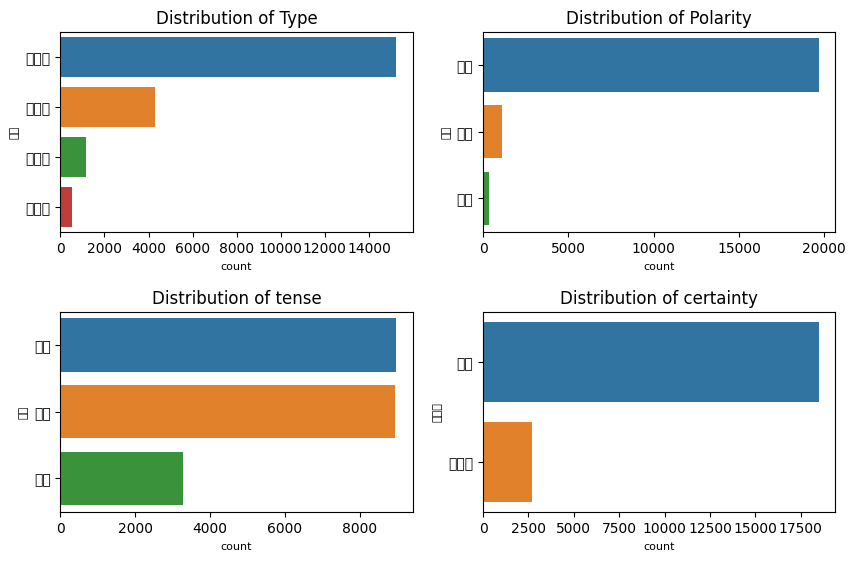

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.4)

g = sns.countplot(y="유형", data=aug,order = aug['유형'].value_counts().index , ax = axes[0][0])
axes[0][0].set_xlabel(g.get_xlabel(), fontsize=8)
axes[0][0].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[0][0].set_title('Distribution of Type')

g = sns.countplot(y="극성", data=aug,order = aug['극성'].value_counts().index , ax = axes[0][1])
axes[0][1].set_xlabel(g.get_xlabel(), fontsize=8)
axes[0][1].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[0][1].set_title('Distribution of Polarity')

g = sns.countplot(y="시제", data=aug,order = aug['시제'].value_counts().index , ax = axes[1][0])
axes[1][0].set_xlabel(g.get_xlabel(), fontsize=8)
axes[1][0].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[1][0].set_title('Distribution of tense')

g = sns.countplot(y="확실성", data=aug,order = aug['확실성'].value_counts().index , ax = axes[1][1])
axes[1][1].set_xlabel(g.get_xlabel(), fontsize=8)
axes[1][1].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[1][1].set_title('Distribution of certainty')

In [2]:
aug = pd.read_csv('train_backTrans.csv')
aug['유형'].value_counts()

사실형    15223
추론형     4292
대화형     1146
예측형      512
Name: 유형, dtype: int64

In [3]:
a = aug[(aug['유형']=='예측형') & (aug['확실성']=='불확실') & (aug['극성']=='부정')]
b = aug[(aug['유형']=='예측형') & (aug['확실성']=='불확실') & (aug['극성']=='미정')]
c = aug[(aug['유형']=='대화형') & (aug['확실성']=='불확실') & (aug['극성']=='미정')]
d = aug[(aug['유형']=='대화형') & (aug['확실성']=='불확실') & (aug['극성']=='부정')]

In [4]:
df = pd.concat([a,b,c,d])
df = df.reset_index(drop=True)
df

,문장,유형,극성,시제,확실성,label
0,이달 24~27일(현지시간) 스페인 바르셀로나에서 열리는 세계최대 모바일 전시회 모...,예측형,부정,현재,불확실,예측형-부정-현재-불확실
1,신종 코로나바이러스 감염증(우한 폐렴) 사태 수습과 내수 정상화에 힘써야 할 중국이...,예측형,부정,미래,불확실,예측형-부정-미래-불확실
2,확실히 백내장 진단을 받았어도 입원 치료를 받을 만큼 특별한 상황이었음을 입증하지 ...,예측형,부정,미래,불확실,예측형-부정-미래-불확실
3,"결국 국내 은행들은 상대적으로 손쉬운 이자 장사에만 다시 몰두할 것이고, 외국인 투...",예측형,부정,미래,불확실,예측형-부정-미래-불확실
4,이달 24일부터 27일까지 스페인 바르셀로나에서 열리는 세계 최대 모바일 전시회인 ...,예측형,부정,현재,불확실,예측형-부정-현재-불확실
...,...,...,...,...,...,...
161,긴 밥과 튀긴 그룹과 비슷할 수도 없다.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
162,아내가 해야 할 일을 하지 않은 것을 어떻게 탓할 수 있겠어요?,대화형,부정,과거,불확실,대화형-부정-과거-불확실
163,단기 조정은 있을 수 있지만 지난해 11월 이후 같은 하락 가능성은 크지 않다.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
164,"""노인 일자리""의 증가를 비판하는 것에 지치지 않았나요?＂",대화형,부정,현재,불확실,대화형-부정-현재-불확실


# MLM모델 이용 Synonym Replacement

In [5]:
def tokenize(tokenizer:AutoTokenizer, sent:str):
    encoded_dict = tokenizer(
        sent,
        add_special_tokens = True,
        return_attention_mask = True,
        return_tensors = "pt"
    )
    input_id, attention_mask = encoded_dict.input_ids, encoded_dict.attention_mask

    return input_id, attention_mask

def is_same_token_type(org_token:str, candidate:str) -> bool:
    '''
    후보 필터링 조건을 만족하는지 확인
    - 후보와 원 토큰의 타입을 문장부호와 일반 토큰으로 나누어 같은 타입에 속하는지 확인
    '''
    res = False
    if org_token[0]=="#" and org_token[2:].isalpha()==candidate.isalpha():
        res = True
    elif candidate[0]=="#" and org_token.isalpha()==candidate[2:].isalpha():
        res = True
    elif candidate[0]=="#" and org_token[0]=="#" and org_token[2:].isalpha()==candidate[2:].isalpha():
        res = True
    elif org_token.isalpha()==candidate.isalpha() and (candidate[0]!="#" and org_token[0]!="#"):
        res = True

    return res

def candidate_filtering(tokenizer:AutoTokenizer,
                        input_ids:list,
                        idx:int,
                        org:int,
                        candidates:Union[list, torch.Tensor]) -> int:
    '''
    후보 필터링 조건에 만족하는 최적의 후보 선택
    1. 원래 토큰과 후보 토큰이 같은 타입(is_same_token_type 참고)
    2. 현 위치 앞 혹은 뒤에 동일한 토큰이 있지 않음
    '''

    org_token = tokenizer.convert_ids_to_tokens([org])[0]
    candidate_tokens = tokenizer.convert_ids_to_tokens(candidates.cpu().tolist())

    for rank, token in enumerate(candidate_tokens):
        if org_token!=token and is_same_token_type(org_token, token):
            if input_ids[idx-1]==candidates[rank] or input_ids[idx+1]==candidate_tokens[rank]:
                continue
            return candidates[rank]

    return org

def augment_one_sent(model:AutoModelForMaskedLM,
                    tokenizer:AutoTokenizer,
                    sent:str,
                    dev:Union[str, torch.device]) -> str:

    k = 5
    threshold = 0.95
    mlm_prob = 0.15

    model.eval()

    input_id, attention_mask  = tokenize(tokenizer, sent)
    org_ids = copy.deepcopy(input_id[0])
    
    masked_input_id, _ = mask_tokens(tokenizer, input_id, mlm_prob, do_rep_random=False)
    while masked_input_id.cpu().tolist()[0].count(tokenizer.mask_token_id) < 1:
        masked_input_id, _ = mask_tokens(tokenizer, input_id, mlm_prob, do_rep_random=False)
    
    with torch.no_grad():
        masked_input_id, attention_mask = masked_input_id.to(dev), attention_mask.to(dev)
        output = model(masked_input_id, attention_mask = attention_mask)
        logits = output["logits"][0]

    copied = copy.deepcopy(masked_input_id.cpu().tolist()[0])
    for i in range(len(copied)):
        if copied[i] == tokenizer.mask_token_id:
            org_token = org_ids[i]
            prob = logits[i].softmax(dim=0)
            probability, candidates = prob.topk(k)
            if probability[0]<threshold:
                res = candidate_filtering(tokenizer, copied, i, org_token, candidates)
            else:
                res = candidates[0]
            copied[i] = res

    copied = tokenizer.decode(copied, skip_special_tokens=True)

    return copied

In [6]:
dev = "cuda:{}".format(0)
dev = "cpu"
        
model = AutoModelForMaskedLM.from_pretrained("seoyeon96/KcELECTRA-MLM")
tokenizer = AutoTokenizer.from_pretrained("seoyeon96/KcELECTRA-MLM")

model.to(dev)

ElectraForMaskedLM(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(50135, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## 문장, 유형, 극성, 시제, 확실성, label

In [7]:
df

,문장,유형,극성,시제,확실성,label
0,이달 24~27일(현지시간) 스페인 바르셀로나에서 열리는 세계최대 모바일 전시회 모...,예측형,부정,현재,불확실,예측형-부정-현재-불확실
1,신종 코로나바이러스 감염증(우한 폐렴) 사태 수습과 내수 정상화에 힘써야 할 중국이...,예측형,부정,미래,불확실,예측형-부정-미래-불확실
2,확실히 백내장 진단을 받았어도 입원 치료를 받을 만큼 특별한 상황이었음을 입증하지 ...,예측형,부정,미래,불확실,예측형-부정-미래-불확실
3,"결국 국내 은행들은 상대적으로 손쉬운 이자 장사에만 다시 몰두할 것이고, 외국인 투...",예측형,부정,미래,불확실,예측형-부정-미래-불확실
4,이달 24일부터 27일까지 스페인 바르셀로나에서 열리는 세계 최대 모바일 전시회인 ...,예측형,부정,현재,불확실,예측형-부정-현재-불확실
...,...,...,...,...,...,...
161,긴 밥과 튀긴 그룹과 비슷할 수도 없다.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
162,아내가 해야 할 일을 하지 않은 것을 어떻게 탓할 수 있겠어요?,대화형,부정,과거,불확실,대화형-부정-과거-불확실
163,단기 조정은 있을 수 있지만 지난해 11월 이후 같은 하락 가능성은 크지 않다.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
164,"""노인 일자리""의 증가를 비판하는 것에 지치지 않았나요?＂",대화형,부정,현재,불확실,대화형-부정-현재-불확실


In [8]:
list = []
for i in df['문장']:
    list.append(i)
list

['이달 24~27일(현지시간) 스페인 바르셀로나에서 열리는 세계최대 모바일 전시회 모바일월드 콩그레스(MWC)에 참가하는 국내 기업들도 줄어들 것으로 보인다.',
 '신종 코로나바이러스 감염증(우한 폐렴) 사태 수습과 내수 정상화에 힘써야 할 중국이 미국과 약속한 2000억달러(약 231조원) 추가 구매를 제대로 이행하기는 어려울 것이다.',
 '확실히 백내장 진단을 받았어도 입원 치료를 받을 만큼 특별한 상황이었음을 입증하지 못하면 30만원 이상의 보험금을 받기 어려울 전망이다.',
 '결국 국내 은행들은 상대적으로 손쉬운 이자 장사에만 다시 몰두할 것이고, 외국인 투자자들은 한국 금융사를 더 이상 쳐다보지 않을 것이다.',
 '이달 24일부터 27일까지 스페인 바르셀로나에서 열리는 세계 최대 모바일 전시회인 모바일월드콩그레스(MWC)에 참가하는 국내 업체도 줄어들 전망이다.',
 '신종 코로나바이러스 감염증(우한 폐렴)을 처리하고 내수를 정상화해야 하는 중국이 미국과 약속한 2000억달러(약 231조원) 규모의 추가 구매를 제대로 이행하기는 어려울 것으로 보인다.',
 '백내장 진단을 받았더라도 입원치료를 받을 만큼 특별한 상황이었다는 사실을 입증하지 못하면 30만원 이상의 보험금을 받기 어려울 것으로 예상된다.',
 '결국 국내 은행들은 상대적으로 손쉬운 이자 사업에 다시 집중하고, 외국인 투자자들은 더 이상 한국 금융회사들을 쳐다보지 않을 것이다.',
 '해상에서는 서해상을 중심으로 돌풍과 함께 천둥·번개가 치는 곳이 있겠다.',
 '제9호 태풍 ＇마이삭(MAYSAK)＇이 오는 2~3일 전국에 강한 바람과 함께 일부 지역에는 400㎜ 이상의 물폭탄이 예상된다.',
 '한편 17일 낮 기온이 전날 대비 3~5도 내외로 올라 평년보다 조금 높겠다.',
 '이튿날인 18일 아침최저기온은 19~23도, 낮최고기온은 26~32도를 기록할 전망이다.',
 '숙박 O2O(Online to Offline, 온라인 기반 오프라인) 플랫폼 업계 1·2위를 차지하고 있는

In [9]:
aug_list = []

for i in list:
    aug = augment_one_sent(model, tokenizer, i, dev)
    aug_list.append(aug)

In [10]:
new_text = pd.DataFrame(aug_list, columns=['aug'])
new_train = pd.concat([df, new_text], axis=1)
new_train

,문장,유형,극성,시제,확실성,label,aug
0,이달 24~27일(현지시간) 스페인 바르셀로나에서 열리는 세계최대 모바일 전시회 모...,예측형,부정,현재,불확실,예측형-부정-현재-불확실,"이달 24 ~ 27일 ( 현지 ), 스페인 바르셀로나에서 열리는 국내최대 모바일 전..."
1,신종 코로나바이러스 감염증(우한 폐렴) 사태 수습과 내수 정상화에 힘써야 할 중국이...,예측형,부정,미래,불확실,예측형-부정-미래-불확실,신종 코로나바이러스 감염증 ( 우한 폐렴 ) 사태 수습하고 내수 정상화에 힘쓰야 할...
2,확실히 백내장 진단을 받았어도 입원 치료를 받을 만큼 특별한 상황이었음을 입증하지 ...,예측형,부정,미래,불확실,예측형-부정-미래-불확실,확실히 백단장 진단을 받어도 미국에서 치료를 받을 만큼 특별한 일이었음을 입증하지 ...
3,"결국 국내 은행들은 상대적으로 손쉬운 이자 장사에만 다시 몰두할 것이고, 외국인 투...",예측형,부정,미래,불확실,예측형-부정-미래-불확실,"결국 국내 은행들은 상대적으로 한국한 장사에 다시 몰두할 것이고, 외국인 사업가들은..."
4,이달 24일부터 27일까지 스페인 바르셀로나에서 열리는 세계 최대 모바일 전시회인 ...,예측형,부정,현재,불확실,예측형-부정-현재-불확실,이달 24일부터 27일까지는 스페인 바르셀로나에서 열리는 세계 최고의 모바일 전시회...
...,...,...,...,...,...,...,...
161,긴 밥과 튀긴 그룹과 비슷할 수도 없다.,대화형,부정,현재,불확실,대화형-부정-현재-불확실,긴 밥과 비긴 나물과 비슷 할 수도 없다.
162,아내가 해야 할 일을 하지 않은 것을 어떻게 탓할 수 있겠어요?,대화형,부정,과거,불확실,대화형-부정-과거-불확실,아내가 해야 할 일을 하지 않은 것을 어떻게 탓할 수 있겠어요.
163,단기 조정은 있을 수 있지만 지난해 11월 이후 같은 하락 가능성은 크지 않다.,대화형,부정,현재,불확실,대화형-부정-현재-불확실,단기 하락은 있을 수 있지만 지난해 11월 이후 같은 하락 확률은 크지 않다.
164,"""노인 일자리""의 증가를 비판하는 것에 지치지 않았나요?＂",대화형,부정,현재,불확실,대화형-부정-현재-불확실,""" 청년 일자리 "" 의 증가를 비판하는 것에 지치지 않았나요? ＂"


In [11]:
new_train.drop(columns=['문장'], inplace=True)
new_train.rename(columns={'aug':'문장'}, inplace=True)

new_c = new_train.columns[-1:].to_list() + new_train.columns[:-1].to_list()
new_train = new_train[new_c]
new_train

,문장,유형,극성,시제,확실성,label
0,"이달 24 ~ 27일 ( 현지 ), 스페인 바르셀로나에서 열리는 국내최대 모바일 전...",예측형,부정,현재,불확실,예측형-부정-현재-불확실
1,신종 코로나바이러스 감염증 ( 우한 폐렴 ) 사태 수습하고 내수 정상화에 힘쓰야 할...,예측형,부정,미래,불확실,예측형-부정-미래-불확실
2,확실히 백단장 진단을 받어도 미국에서 치료를 받을 만큼 특별한 일이었음을 입증하지 ...,예측형,부정,미래,불확실,예측형-부정-미래-불확실
3,"결국 국내 은행들은 상대적으로 한국한 장사에 다시 몰두할 것이고, 외국인 사업가들은...",예측형,부정,미래,불확실,예측형-부정-미래-불확실
4,이달 24일부터 27일까지는 스페인 바르셀로나에서 열리는 세계 최고의 모바일 전시회...,예측형,부정,현재,불확실,예측형-부정-현재-불확실
...,...,...,...,...,...,...
161,긴 밥과 비긴 나물과 비슷 할 수도 없다.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
162,아내가 해야 할 일을 하지 않은 것을 어떻게 탓할 수 있겠어요.,대화형,부정,과거,불확실,대화형-부정-과거-불확실
163,단기 하락은 있을 수 있지만 지난해 11월 이후 같은 하락 확률은 크지 않다.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
164,""" 청년 일자리 "" 의 증가를 비판하는 것에 지치지 않았나요? ＂",대화형,부정,현재,불확실,대화형-부정-현재-불확실


In [12]:
df = pd.concat([df, new_train])
df = df.reset_index(drop=True)
df

,문장,유형,극성,시제,확실성,label
0,이달 24~27일(현지시간) 스페인 바르셀로나에서 열리는 세계최대 모바일 전시회 모...,예측형,부정,현재,불확실,예측형-부정-현재-불확실
1,신종 코로나바이러스 감염증(우한 폐렴) 사태 수습과 내수 정상화에 힘써야 할 중국이...,예측형,부정,미래,불확실,예측형-부정-미래-불확실
2,확실히 백내장 진단을 받았어도 입원 치료를 받을 만큼 특별한 상황이었음을 입증하지 ...,예측형,부정,미래,불확실,예측형-부정-미래-불확실
3,"결국 국내 은행들은 상대적으로 손쉬운 이자 장사에만 다시 몰두할 것이고, 외국인 투...",예측형,부정,미래,불확실,예측형-부정-미래-불확실
4,이달 24일부터 27일까지 스페인 바르셀로나에서 열리는 세계 최대 모바일 전시회인 ...,예측형,부정,현재,불확실,예측형-부정-현재-불확실
...,...,...,...,...,...,...
327,긴 밥과 비긴 나물과 비슷 할 수도 없다.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
328,아내가 해야 할 일을 하지 않은 것을 어떻게 탓할 수 있겠어요.,대화형,부정,과거,불확실,대화형-부정-과거-불확실
329,단기 하락은 있을 수 있지만 지난해 11월 이후 같은 하락 확률은 크지 않다.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
330,""" 청년 일자리 "" 의 증가를 비판하는 것에 지치지 않았나요? ＂",대화형,부정,현재,불확실,대화형-부정-현재-불확실


In [19]:
list = []

for i in df['문장']:
    list.append(i)

aug_list = []

for i in list:
    aug = augment_one_sent(model, tokenizer, i, dev)
    aug_list.append(aug)
    
new_text = pd.DataFrame(aug_list, columns=['aug'])
new_train = pd.concat([df, new_text], axis=1)

In [20]:
new_train.drop(columns=['문장'], inplace=True)
new_train.rename(columns={'aug':'문장'}, inplace=True)

new_c = new_train.columns[-1:].to_list() + new_train.columns[:-1].to_list()
new_train = new_train[new_c]

df = pd.concat([df, new_train])
df = df.reset_index(drop=True)
df

,문장,유형,극성,시제,확실성,label
0,이달 24~27일(현지시간) 스페인 바르셀로나에서 열리는 세계최대 모바일 전시회 모...,예측형,부정,현재,불확실,예측형-부정-현재-불확실
1,신종 코로나바이러스 감염증(우한 폐렴) 사태 수습과 내수 정상화에 힘써야 할 중국이...,예측형,부정,미래,불확실,예측형-부정-미래-불확실
2,확실히 백내장 진단을 받았어도 입원 치료를 받을 만큼 특별한 상황이었음을 입증하지 ...,예측형,부정,미래,불확실,예측형-부정-미래-불확실
3,"결국 국내 은행들은 상대적으로 손쉬운 이자 장사에만 다시 몰두할 것이고, 외국인 투...",예측형,부정,미래,불확실,예측형-부정-미래-불확실
4,이달 24일부터 27일까지 스페인 바르셀로나에서 열리는 세계 최대 모바일 전시회인 ...,예측형,부정,현재,불확실,예측형-부정-현재-불확실
...,...,...,...,...,...,...
2651,긴 나물과 안긴 나물과 비슷 할 수 있다.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
2652,아내를 사랑할 일이가 없는 걸 어떻게 설명 할 수가 있겠습니까.,대화형,부정,과거,불확실,대화형-부정-과거-불확실
2653,단기 하락은 있을 수 있지만 올해 11월부터 장기 하락 가능성은 크지 않음.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
2654,""" 청년 일자리 "" 이란 영화가 만드는 것에 지치지 않았나요??",대화형,부정,현재,불확실,대화형-부정-현재-불확실


In [21]:
orig = pd.read_csv('train_backTrans.csv')
new = pd.concat([orig, df])
new = new.reset_index(drop=True)
new.to_csv('train_aug_2.csv', index=False)

In [22]:
for i in range(0, len(new)):
    new.at[i, '문장'] = new['문장'][i].replace('.?','?')

In [23]:
new.to_csv('train_aug_2.csv', index=False)

Text(0.5, 1.0, 'Distribution of certainty')

findfont: Font family ['NanumGothicOTF'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothicOTF'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothicOTF'] not found. Falling back to DejaVu Sans.
/root/anaconda3/envs/dacon/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  func(*args, **kwargs)
/root/anaconda3/envs/dacon/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  func(*args, **kwargs)
/root/anaconda3/envs/dacon/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  func(*args, **kwargs)
/root/anaconda3/envs/dacon/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from current font.
  func(*args, **kwargs)
/root/anaconda3/envs

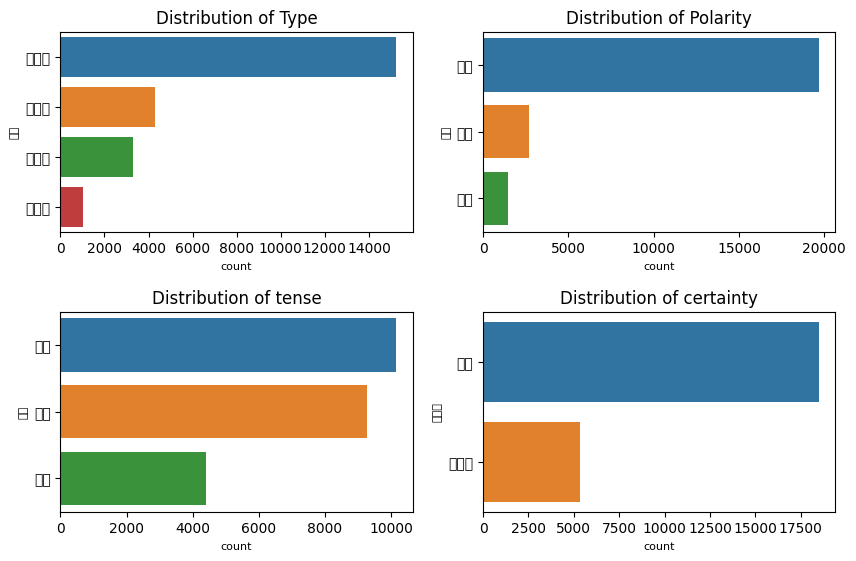

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.4)

g = sns.countplot(y="유형", data=new,order = new['유형'].value_counts().index , ax = axes[0][0])
axes[0][0].set_xlabel(g.get_xlabel(), fontsize=8)
axes[0][0].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[0][0].set_title('Distribution of Type')

g = sns.countplot(y="극성", data=new,order = new['극성'].value_counts().index , ax = axes[0][1])
axes[0][1].set_xlabel(g.get_xlabel(), fontsize=8)
axes[0][1].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[0][1].set_title('Distribution of Polarity')

g = sns.countplot(y="시제", data=new,order = new['시제'].value_counts().index , ax = axes[1][0])
axes[1][0].set_xlabel(g.get_xlabel(), fontsize=8)
axes[1][0].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[1][0].set_title('Distribution of tense')

g = sns.countplot(y="확실성", data=new,order = new['확실성'].value_counts().index , ax = axes[1][1])
axes[1][1].set_xlabel(g.get_xlabel(), fontsize=8)
axes[1][1].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[1][1].set_title('Distribution of certainty')

In [29]:
od = pd.read_csv('train_dup.csv')
od['유형'].value_counts()

사실형    13527
추론형     2146
대화형      573
예측형      256
Name: 유형, dtype: int64

In [25]:
new['유형'].value_counts()

사실형    15223
추론형     4292
대화형     3290
예측형     1024
Name: 유형, dtype: int64

In [30]:
od['극성'].value_counts()

긍정    15754
부정      565
미정      183
Name: 극성, dtype: int64

In [26]:
new['극성'].value_counts()

긍정    19677
미정     2702
부정     1450
Name: 극성, dtype: int64

In [31]:
od['시제'].value_counts()

과거    8013
현재    6849
미래    1640
Name: 시제, dtype: int64

In [27]:
new['시제'].value_counts()

현재    10149
과거     9280
미래     4400
Name: 시제, dtype: int64

In [32]:
od['확실성'].value_counts()

확실     15160
불확실     1342
Name: 확실성, dtype: int64

In [28]:
new['확실성'].value_counts()

확실     18489
불확실     5340
Name: 확실성, dtype: int64

In [33]:
from sklearn.model_selection import train_test_split

train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, random_state=0, stratify = df["유형"])
train_p, val_p, _, _ = train_test_split(df, df['label'], test_size=0.2, random_state=0, stratify = df["극성"])

train.to_csv('train_aug_type.csv', index=False)
val.to_csv('val_aug_type.csv', index=False)
train_p.to_csv('train_aug_polarity.csv', index=False)
val_p.to_csv('val_aug_polarity.csv', index=False)

In [37]:
val_p

,문장,유형,극성,시제,확실성,label
2181,"정해인은 18년 아침 황금시언수는 19 ~ 24도, 낮 최고기언은 26 ~ 32로 ...",예측형,미정,미래,불확실,예측형-미정-미래-불확실
2407,국보 1호 숭례문 현판은 과연 얼마나 멋있을까?,대화형,미정,과거,불확실,대화형-미정-과거-불확실
1016,도시가 서해상을 중심으로 돌풍과 함께 화산 · 번개를 치는 이유가 있겠다.,예측형,미정,미래,불확실,예측형-미정-미래-불확실
2549,볼일을 보고 꼭지만지면 그걸로 남자로 생각하냐고.,대화형,미정,과거,불확실,대화형-미정-과거-불확실
1375,어떤 스윙스.,대화형,미정,현재,불확실,대화형-미정-현재-불확실
...,...,...,...,...,...,...
2490,"이달 24 ~ 24일 ( LA ), 스페인 뉴욕에서 열리는 국내최대 아이돌 전시회 ...",예측형,부정,현재,불확실,예측형-부정-현재-불확실
2611,침대에선 어떤가요?,대화형,미정,현재,불확실,대화형-미정-현재-불확실
593,저 핵의 5분의 1에 투자한 핵 경제력이 과연 인구 위기에 대한 남한의 마지막 희망일까.,대화형,미정,미래,불확실,대화형-미정-미래-불확실
1420,공짜로 돈 나눠주겠다는데 반대할 도민이 과연 있을까.,대화형,미정,현재,불확실,대화형-미정-현재-불확실
